In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft,fftshift,ifftshift

# The nonlinear Schroedinger equation
We consider the nonlinear Schroedinger equation
$$ iz_t + \frac{1}{2}z_{xx} + |z|^2z = 0,\quad x\in[-5,5],\quad t \in \left[0,\frac{\pi}{2}\right],$$
where $z(t,x) = u(t,x) + iv(t,x)$ is a comples-valued function. We impose the initial condition
$$z(0,x) = \frac{4}{e^x + e^{-x}}$$
and periodic boundary conditions
$$z(t,-5) = z(t,5),\quad z_x(t,-5) = z_x(t,5).$$
We will solve this equation using the Fourier spectral method to obtain the reference solution (the ground truth).

We will work in the complex space. We rewrite the equation as
$$
z_t = \tfrac{i}{2}z_{xx} + i|z|^2z\equiv \mathcal{L}z + \mathcal{N}(z),
$$
where we have split the right-hand side into linear and nonlinear operator.
Now we make a variable change $z = e^{t\mathcal{L}}w$, where $w$ is the new unknown function and $e^{t\mathcal{L}}$ is the solution operator for the linear PDE $w_t = \mathcal{L}w$.

In [4]:
N = 256 # the number of points in space. The best is to use a power of 2.
L = 10 # the length of the interval of x. 
x = np.linspace(-0.5*L,0.5*L,N+1)
wave_nums = np.arange(-N/2,N/2) # -N/2 ... N/2 - 1
freqs = (2*np.pi/L)*wave_nums # frequencies

Nt = 1000000
Tspan = 0.5*np.pi
dt = Tspan/Nt # time step size

# define the linear-part solution operator for one time step
def Lin_sol_operator(z,tau):
    fac = np.exp(-0.5*1j*(freqs**2)*tau) # the solution operator for u_t = u_{xx} in the Fourier space
    Lz = fac*z
    return Lz

# the inverse of the linear-part solution operator
def iLin_sol_operator(w,tau):
    ifac = np.exp(0.5*1j*(freqs**2)*tau) # the inverse solution operator for u_t = u_{xx} in the Fourier space
    iLw = ifac*w
    return iLw

# the four-stage fourth-order Runge-Kutta method 
def RK4step(y,dt,rhs):
    k1 = rhs(0,y)
    k2 = rhs(0.5*dt,y + 0.5*dt*k1)
    k3 = rhs(0.5*dt,y + 0.5*dt*k2)
    k4 = rhs(dt,y + dt*k3)
    return y + dt*(k1 + 2*(k2 + k3) + k4)/6

# the right-hand side of equation (*) in the Fourier space 
# y_t = e^{-dtL}N(e^{dtL}y)
def RHS_Fourier_space(tau,y_F):
    etLy_F = Lin_sol_operator(y_F,tau)
    # return to the x-space to apply the nonlinear operator
    etLy = ifft(ifftshift(etLy_F))
    # apply the nonlinear operator
    aux = np.real(etLy)**2 + np.imag(etLy)**2
    NetLy = 1j*aux*etLy
    # return to the Fourier space and apply the inverse linear operator
    NetLy_F = fftshift(fft(NetLy))
    y_F_rhs = iLin_sol_operator(NetLy_F,tau)
    return y_F_rhs
    

In [5]:
# time marching in the Fourier space and save the solution in the x-space
import time
start_cpu_time = time.process_time()

skip = 1000 # save every (skip)th step
Nsave = int(Nt/skip + 1)
sol_save = np.zeros((N,Nsave),dtype=complex)

# the initial condition
sol_save[:,0] = 4/(np.exp(x[:-1]) + np.exp(-x[:-1]))
z = sol_save[:,0] 

# go to the Fourier space
z_F = fftshift(fft(z))
                            
jsave = 0
for j in range(Nt):
    w_F_new = RK4step(z_F,dt,RHS_Fourier_space)    
    z_F = Lin_sol_operator(w_F_new,dt)
    if j % skip == 0:
        # return to the x-space and save the solution
        jsave = jsave + 1
        sol_save[:,jsave] = ifft(ifftshift(z_F))
        if jsave % 100 == 0:
            print("jsave = ",jsave)


end_cpu_time = time.process_time()
cpu_execution_time = end_cpu_time - start_cpu_time
print(f"CPU Execution time: {cpu_execution_time:.6f} seconds")

jsave =  100
jsave =  200
jsave =  300
jsave =  400
jsave =  500
jsave =  600
jsave =  700
jsave =  800
jsave =  900
jsave =  1000
CPU Execution time: 125.111106 seconds


(257, 1001)


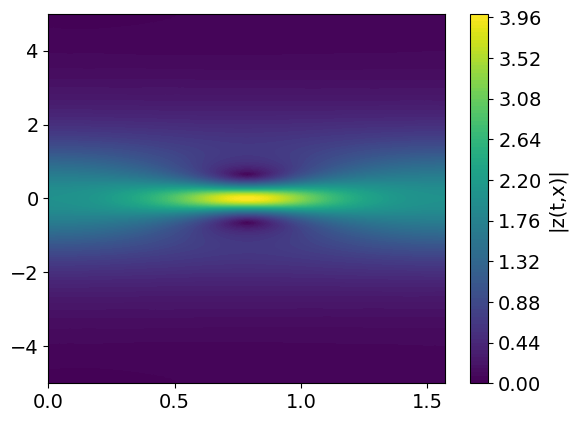

In [30]:
# visualize the solution as a heatmap
asol = np.abs(sol_save)
asol = np.concatenate((asol,np.reshape(asol[0,:],(1,Nsave))),axis = 0)
print(np.shape(asol))
tplot = np.linspace(0,Tspan,Nsave)

plt.rcParams.update({'font.size': 14})
plt.contourf(tplot,x,asol,levels = 100)
plt.colorbar(label="|z(t,x)|", orientation="vertical")
plt.xlabel("t")
plt.ylabel("x")
# save the solution
fname = "NLSE_spectral_solution.npz"
np.savez(fname,t = tplot, x = x, u = np.real(sol_save), v = np.imag(sol_save))


t =  0.59  ind =  375
t =  0.79  ind =  502
t =  0.98  ind =  623


Text(0, 0.5, '|z|')

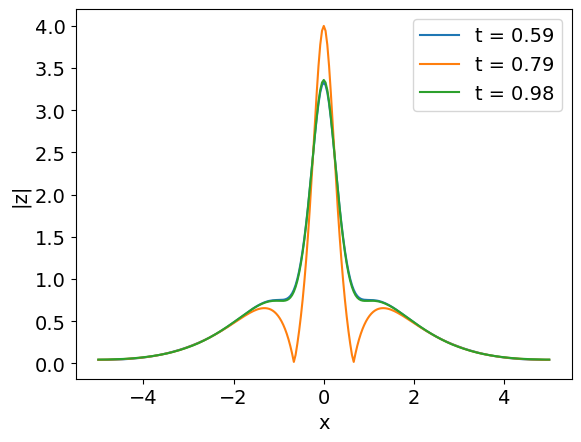

In [7]:
t_query = np.array([0.59,0.79,0.98])
N_query = np.size(t_query)
for j in range(N_query):
    ind = np.floor(t_query[j]/(dt*skip)).astype(int)
    print("t = ",t_query[j]," ind = ",ind)
    plt.plot(x,asol[:,ind],label = f"t = {t_query[j]:.2f}")
plt.legend()
plt.xlabel("x")
plt.ylabel("|z|")

t = 0.00, ind = 0
t = 0.10, ind = 63
t = 0.20, ind = 127
t = 0.30, ind = 190
t = 0.40, ind = 254
t = 0.50, ind = 318
t = 0.60, ind = 381
t = 0.70, ind = 445
t = 0.80, ind = 509
t = 0.90, ind = 572
t = 1.00, ind = 636
t = 1.10, ind = 700
t = 1.20, ind = 763
t = 1.30, ind = 827
t = 1.40, ind = 891
t = 1.50, ind = 954


Text(0, 0.5, '|z|')

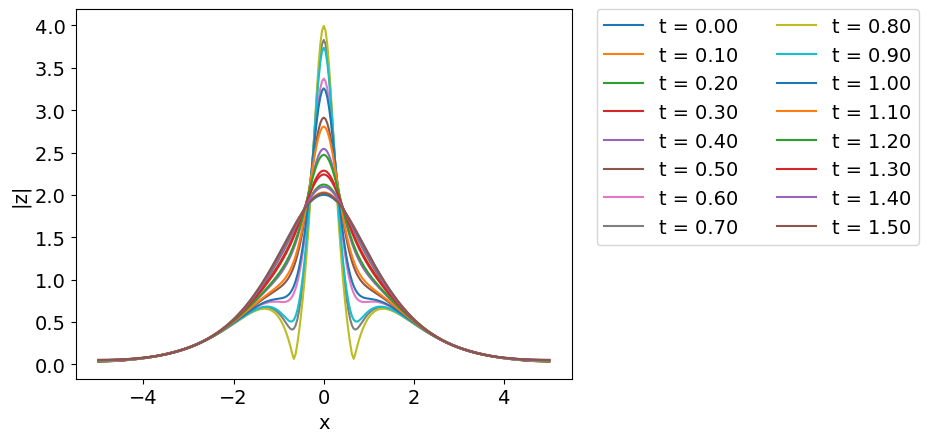

In [8]:
t_query = np.arange(0,Tspan,0.1)
N_query = np.size(t_query)
for j in range(N_query):
    ind = np.floor(t_query[j]/(dt*skip)).astype(int)
    print(f"t = {t_query[j]:.2f}, ind = {ind}")
    plt.plot(x,asol[:,ind],label = f"t = {t_query[j]:.2f}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, borderaxespad=0.)
plt.xlabel("x")
plt.ylabel("|z|")